In [236]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, validation_curve
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             classification_report, roc_curve, auc, roc_auc_score)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_confusion_matrix, plot_learning_curves


%matplotlib inline

In [46]:
df = pd.read_csv('./credit-g.csv')

df = df.replace({'class': {'good': 1, 'bad': 0}}) # Changing text values to integer values

print(df.info())

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
credit_history            1000 non-null object
purpose                   1000 non-null object
credit_amount             1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
 other_payment_plans      1000 non-null object
housing                   1000 non-null object
existing_credits          1000 non-null int64
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
 foreign

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
420,no checking,15,existing paid,new car,3186,>=1000,4<=X<7,2,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,yes,1
796,<0,18,existing paid,used car,7511,no known savings,>=7,1,male single,none,...,life insurance,51,none,for free,1,skilled,2,yes,yes,0
27,>=200,12,all paid,radio/tv,409,>=1000,1<=X<4,3,female div/dep/mar,none,...,real estate,42,none,rent,2,skilled,1,none,yes,1
407,<0,15,existing paid,radio/tv,1053,<100,<1,4,male mar/wid,none,...,real estate,27,none,own,1,skilled,1,none,no,1
211,no checking,36,existing paid,radio/tv,3835,no known savings,>=7,2,female div/dep/mar,none,...,real estate,45,none,own,1,unskilled resident,1,yes,yes,1


In [193]:
cleaning_pipeline = ColumnTransformer(transformers=[
    ("categorical_transformer", OneHotEncoder(),
     ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'installment_commitment',
      'personal_status', 'other_parties', 'residence_since', 'property_magnitude', ' other_payment_plans',
      'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', ' foreign_worker'
     ]),
    ("numerical_transformer", StandardScaler(), ['duration', 'credit_amount', 'age'])
])

pipe = Pipeline(steps=[
    # ('feature_selection', SelectKBest(k=3)),
    ('cleaning', cleaning_pipeline),
    
    ('classification', LogisticRegression(solver='lbfgs'))])

In [186]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)


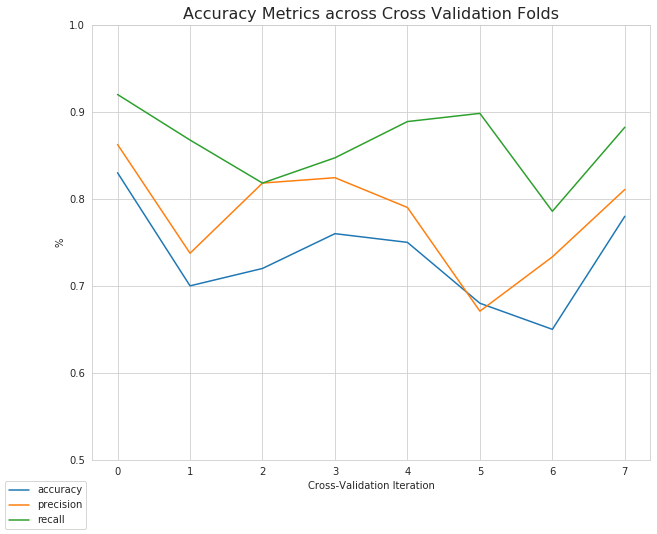

In [281]:
sns.set_style("whitegrid")

performance = []
for train_index1, test_index in KFold(n_splits=8).split(X_train):
    X_train1, X_test = X.iloc[train_index1], X.iloc[test_index]
    y_train1, y_test = y.iloc[train_index1], y.iloc[test_index]
    pipe.fit(X_train1, y_train1)
    y_pred = pipe.predict(X_test)
    performance.append({
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred)})

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot([x['accuracy'] for x in performance], label='accuracy')
ax.plot([x['precision'] for x in performance], label='precision')
ax.plot([x['recall'] for x in performance], label='recall')

ax.set_ylim(.5, 1)
ax.set_ylabel('%')
ax.set_xlabel('Cross-Validation Iteration')
ax.set_title('Accuracy Metrics across Cross Validation Folds',
             fontdict={'fontsize': 16});

fig.legend(loc=3);

## Full Training Set

In [171]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_validation)

In [278]:
sns.set_style("whitegrid")

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix(y_validation, y_pred),
    hide_spines=True, hide_ticks=True,
    figsize=(8, 6))

ax.set_title('Confusion Matrix',
             fontdict={'fontsize': 16});

ValueError: Found input variables with inconsistent numbers of samples: [200, 100]

In [175]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.42      0.44        48
           1       0.82      0.85      0.83       152

    accuracy                           0.74       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.74      0.74      0.74       200



Area under the curve score: 0.833


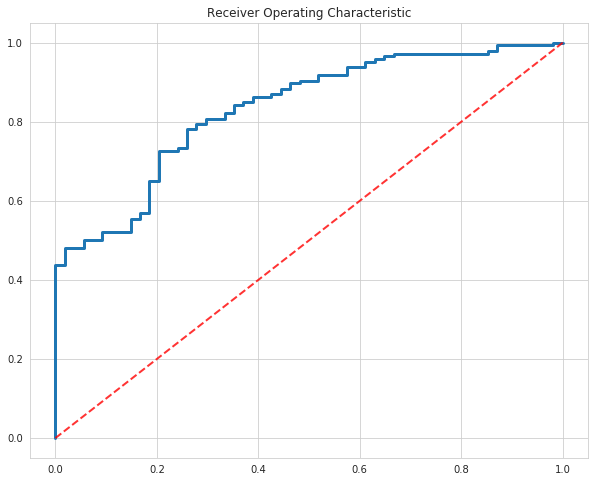

In [277]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))
pred_proba = pipe.predict_proba(X_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, pred_proba)
auc_score = roc_auc_score(y_validation, pred_proba)

ax.plot(fpr, tpr, lw=3)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
ax.set_title('Receiver Operating Characteristic')

print('Area under the curve score: {x:0.3}'.format(x=auc_score))